<a href="https://colab.research.google.com/github/lonen8188/PythonAI/blob/9-2.natural_language_processing(NNP)/hg_09_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 순환 신경망 실습
# IMDB 리뷰 데이터 셋 : 유명한 인터넷 영화 데이터베이스인 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터 셋
# 총 50,000개의 샘플로 훈련데이터와 테스트데이터가 5:5로 나누어져 있음

# 자연어 처리(natural language processing : nlp) : 컴퓨터를 사용해 인간의 언어를 처리하는 분야(음성인식, 기계번역, 감정분석)
# 말뭉치(corpus : 코퍼스) : 자연어 처리 분야에서 훈련데이터를 말함 (IMDB 리뷰 데이터셋이 이에 해당 )

# 텍스트 자체를 신경망에 전달하지 않음. 컴퓨터에서 처리하는 모든 것은 어떤 숫자 데이터이다.
# 합성곱 신경망에서 이미지를 다룰때 특별한 변환을 하지 않았음 (RGB), 이미지가 정수 픽셀 값으로 이루어져 있기 때문이다.
# 텍스트 데이터의 경우 단어를 숫자 데이터로 바꾸는 일반적인 방법은 데이터에 등장하는 단어마다 고유한 정수를 부여한다.

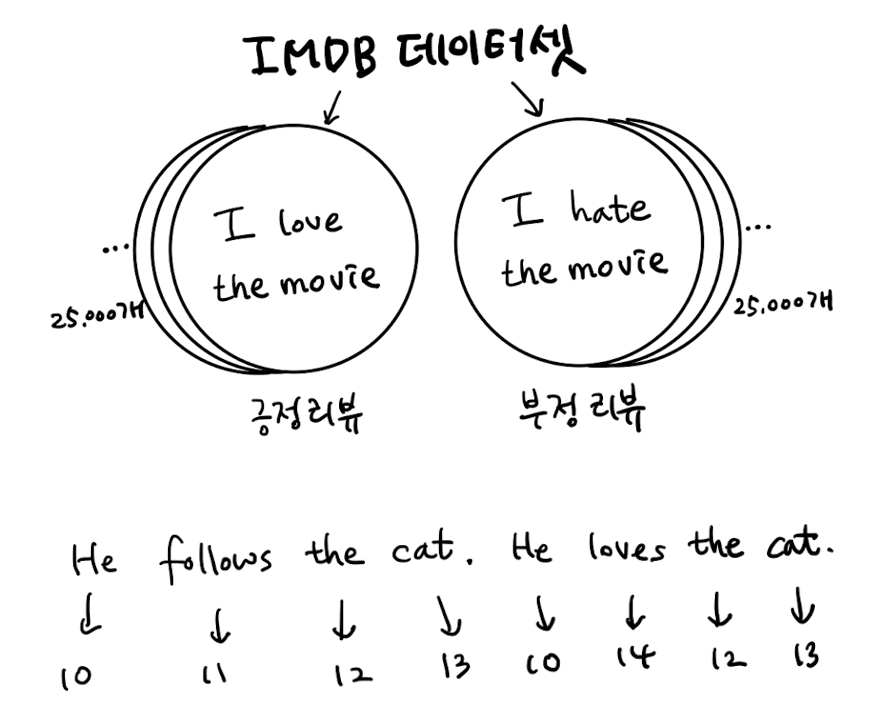

In [1]:
# 앞의 두문장에 등장하는 각 단어를 하나의 정수에 매핑, 동일한 단어는 동일한 정수에 매핑됨
# 단어의 매핑되는 정수는 단어의 의미나 크기와 관련이 없다.
# 위에 그림에 보면 He 를 10으로 매핑, cat을 13에 매핑하더라도 cat이 He 보다 좋거나 크다는 뜻이 아님
# 이 정숫 값 사이에는 어떤 관계도 없음

# 일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점(.,)을 삭제한 다음 공백을 기준으로 분리한다.
# 이렇게 분리된 단어를 토큰(token)이라고 부른다.

# 하나의 샘플은 여러개의 토큰으로 이루어져 있고 1개의 토큰이 하나의 타임스텝에 해당한다.
# 간단한 문제라면 영어 말뭉치에서 토큰을 단어와 같게 봐도 됨(한국어는 조금 다름)
# 한국어인 경우에는 조사가 발달 되어 공백으로 나누는 것보다 형태소 분석을 통해 토큰을 만듬
# https://velog.io/@hunterhunter/%ED%95%9C%EA%B5%AD%EC%96%B4-%ED%98%95%ED%83%9C%EC%86%8C-%EB%B6%84%EC%84%9D-%EA%B8%B0%EC%B4%88

# 토큰에 할당하는 정수 중에 몇개는 특정한 용도로 예약 되어 있다.
# 예를 들어 0은 패딩, 1은 문장의시작 , 2는 어휘 사전에 없는 토큰을 나타냄
# 어휘사전 : 훈련세트에서 고유한 단어를 뽑아 만든 목록(테스트 세트 안에 어휘 사전에 없는 단어가 있다면 2를 변환하여 신경망 모델에 주입함)

# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

In [2]:
# 실제 IMDB 리뷰 데이터셋은 영어로 된 문장이지만 편리하게 텐서플로에는 이미 정수로 바꾼 데이터가 포함되어 있다.
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=200)
# 전체 데이터 셋에서 가장 자주 등장하는 단어 200개만 사용 하겠다. (num_words=200) -> 학생은 300으로 테스트 해봄

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(train_input.shape, test_input.shape) # 훈련세트와 테스트 세트의 크기 확인

(25000,) (25000,)


In [ ]:
# 데이터 셋은 5만개 있으며 5:5로 나누어 져 있음, 배열이 1차원인 것이 확인됨
# IMDB 리뷰 텍스트는 길이가 제각각으로 되어 있다. 그래서 고정 크기의 2차원 배열에 담기보다 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있음
# 아래 그림처럼 이 데이터는 개별 리뷰를 담은 파이썬 리스트 객체로 이루어진 넘파일 배열이다.(넘파일 배열은 정수,실수외에도 파이썬 객체도 담음)

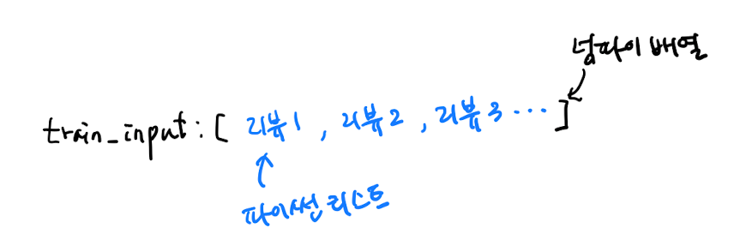

In [4]:
# 0번에 있는 데이터를 출력 해보자.
print(len(train_input[0])) # 218개의 토큰으로 되어 있음

218


In [5]:
# 1번에 있는 데이터를 출력 해보자.
print(len(train_input[1])) # 189개의 토큰으로 되어 있음

189


In [5]:
# 리뷰마다 각각 길이가 다름, 여기서 하나의 리뷰가 하나의 샘플이 됨
# 첫번째 리뷰에 담긴 내용을 출력 해보자.
print(train_input[0])
# 0은 패딩, 1은 문장의시작 , 2는 어휘 사전에 없는 토큰

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 2, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 2, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 2, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 2, 92, 25, 104, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [6]:
# 텐서플로에 있는 IMDB 리뷰 데이터는 이미 정수로 변환되어 있다. 전에 num_words=200으로 지정했음으로 어휘 사전에 200개 단어만 들어가 있음
# 어휘사전에 없는 단어는 2로 표시됨
# 200개의 단어 기준은 imdb.load_date() 함수는 전체 어휘 사전에 있는 단어를 등장 횟수 순서대로 나열한 다음 가장많이 등장한 200개의 단어를 선택함

print(train_target[:20]) # 타깃 데이터를 출력해보자.
# 긍정(1)인지 부정(0)인지 파악하는 타깃

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [7]:
# 해결할 문제는 리뷰가 긍정인지 부정인지를 판단하는 것 -> 이진 분류 문제임
# 데이터를 훈련세트에서 검증세트를 떼어 작업을 하자, 원래 훈련세트 크기가 25,000개 임으로 20%를 검증 세트로 떼어 놓으면 훈련세트 크기가 20,000개로 줄어듬
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [15]:
# 훈련세트에 대해서 각 리뷰의 길이를 계산해 넘파일 배열에 담는다.(평균적인 리뷰의 길이와 가장 짧은 리뷰의 길이 그리고 가장 긴 리뷰의 길이를 확인 할 것!)
# 넘파이 리스트 내포를 사용해 train_input의 원소를 순회하면서 길이를 잼
import numpy as np

lengths = np.array([len(x) for x in train_input]) # lengths 배열이 생성됨 (리뷰의 길이를 담고 있는 배열)
print(np.mean(lengths), np.max(lengths), np.min(lengths), np.median(lengths)) # 평균적인 리뷰의 길이
# 평균, 최대, 최소, 중간값

239.00925 1854 11 178.0


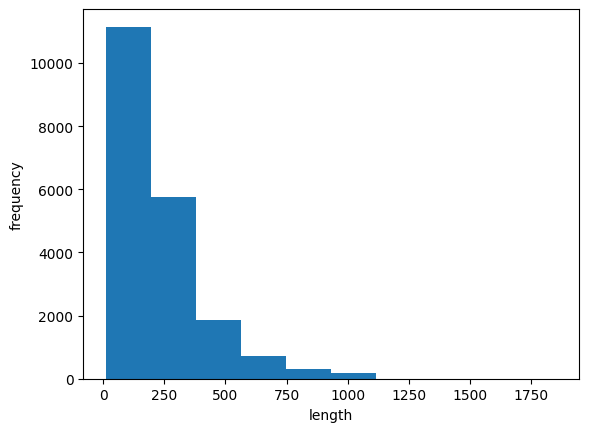

In [16]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')  # 길이
plt.ylabel('frequency') # 빈도
plt.show()
# lengths 배열을 히스토그램(막대그래프)로 출력 해봄
# 왼쪽으로 치우침 (글자수 적은 것이 왼쪽, 글자수 많은 곳이 오른쪽)
# 대부분 리뷰길이는 300 이만이고 평균이 중간값보다 높은 이유임
# 1000개 단어이상의 리뷰도 존재함

In [17]:
# 리뷰는 대부분 짧아서 이 예제에서는 중간값보다 휠씬 짧은 100개의 단어만 사용하려한다. (이유는? )
# 하지만 여전히 100개의 단어보다 작은 리뷰가 있다. 이런 리뷰들의 길이를 100에 맞추려면 패딩이 필요함(보통 패딩을 나타내는 토큰으로 0을 사용함)

# 수동으로 훈련세트에 있는 2만개의 리뷰를 순회하면서 길이가 100이 되도록 잘라내거나 0으로 패딩 할 수 있다.
# 하지만 자주 있는 번거로운 작업엔느 항상 편리한 도구가 준비되어 있음
# 케라스는 시퀀스 데이터의 길이를 맞추는 pad_sequences() 함수를 제공함
# https://yeko90.tistory.com/entry/keras-how-to-padding-with-padsequences

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100, truncating='pre') # pad_sequences() 사용해 train_input의 길이를 100으로 맞춘다.

In [18]:
lengthspd = np.array([len(x) for x in train_seq]) # lengths 배열이 생성됨 (리뷰의 길이를 담고 있는 배열)
print(np.mean(lengthspd), np.max(lengthspd), np.min(lengthspd), np.median(lengthspd)) # 평균적인 리뷰의 길이

100.0 100 100 100.0


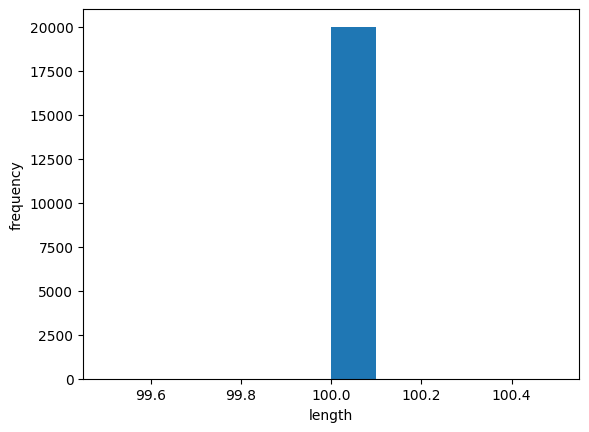

In [19]:
plt.hist(lengthspd)
plt.xlabel('length')  # 길이
plt.ylabel('frequency') # 빈도
plt.show()

In [20]:
print(train_seq.shape) #train_seq 크기 확인
# train_input은 파이선 리스트 배열이었지만 길이를 100으로 맞춘 train_seq는 이제 (20000,100)크기의 2차원 배열이 되었음

(20000, 100)


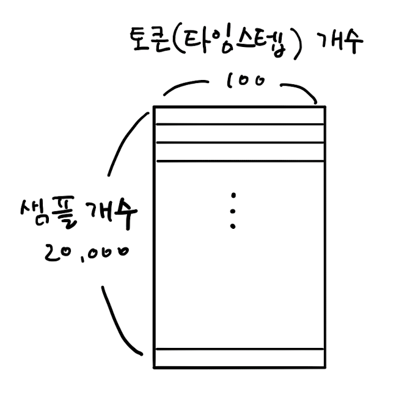

In [21]:
print(train_seq[0]) # 18 * 5 + 10 = 90 + 10 = 100 (앞뒤에 패딩이 없는 것을 봐서는 어디가 잘린 듯??)

[ 10   4  20   9   2   2   2   5  45   6   2   2  33   2   8   2 142   2
   5   2  17  73  17   2   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12   2  69   2 142  73   2   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [12]:
print(train_input[0][-10:]) # train_input에 있는 원본 샘플의 끝쪽을 확인 해보자.
# 음수 인덱스와 슬라이싱을 사용해서 마지막 10개를 확인 해보니 앞쪽이 잘림

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


In [22]:
# pad_sequences() 함수는 기본적으로 maxlen 보다 긴 시퀀스를 가지고 있으면 앞부분을 자름
# 통상적으로 결론은 뒤쪽에 나는 느낌 pad_sequences(truncating='pre')
# 앞쪽을 남기고 뒤쪽을 자르고 싶으면 pad_sequences(truncating ='post')

In [23]:
print(train_seq[5]) # 여섯번째 토큰을 확인 해보면 앞쪽에 0으로 채워짐

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71   2   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14   2  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94   2   2  10  10  87   2  34  49   2   7   2   2   2
   2   2   2   2  46  48  64  18   4   2]


In [24]:
val_seq = pad_sequences(val_input, maxlen=100) # 검증 세트 길이도 100으로 맞춤
# 훈련세트 검증세트 준비 완료

In [28]:
# 순환 신경망 만들기

# 케라스는 여러종류의 순환층 클래스를 제공하지만 가장 간단한 SimpleRNN 클래스를 사용해보자.
# IMDB리뷰 분류 문제는 이진 분류이므로 마지막 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수를 사용할 것임
from tensorflow import keras

model = keras.Sequential() # Sequential()클래스는 순환 신경망, 합성곱 신경망, 일반적인 인공 신경망을 모두 만들 수 있음
# 다만 층을 쌓기 때문에 Sequential클래스로 이름을 붙임 (순차 데이터와 관련없음)

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 200), activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
# Dense나 Conv2D 클래스 데신 SimpleRNN 클래스를 사용함
# activation='tanh' : 활성화 매개변수 기본이 하이퍼볼릭 탄젠트 함수를 사용함 (생략가능)
# SimpleRNN(뉴런의 개수, 입력차원(샘플의길이,imdb.load_data(num_words=200) )
# input_shape의 두번째 차원인 200에 대한 설명
# 이전 세션에서만든 train_seq와 val_seq 은 한 가지 큰 문제가 있다.
# 토큰을 정수로 변환한 이 데이터를 신경망에 주입하면 큰 정수가 활성화 출력을 만들기 때문!!!
# 분명히 이 정수 사이에 어떤 관련이 없다. 20번 토큰을 10번 토큰보다 더 중요시해야 할 이유가 없음
# 따라서 단순한 정숫값을 신경망에 입력하기 위해서는 다른 방식을 찾아야 함
# 정수값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현하는 방법 -> 원-핫인코딩
# 원-핫인코딩 : 정수값을 배열에서 해당 정수 위치의 원소만 1이고 나머지는 0으로 변환 (다중 분류에서 출력층에서 만든 확률과 크로스 엔트로피 손실을 계산하기 위해서 사용함)
# https://wikidocs.net/22647
# train_seq[0]의 첫번째 토큰인 10을 원-핫 인코딩하면 아래와 같은 그림이 됨
# 열한번째 원소만 1이고 나머지는 모두 0인 배열이 되야 됨

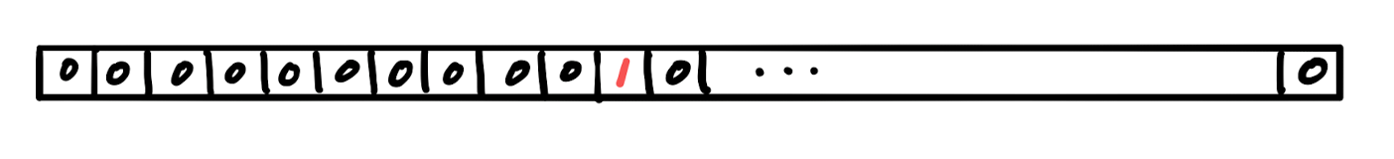

In [30]:
# imdb.load_data(num_words=200)에서 200개의 단어만 사용하도록 지정했기 때문에 고유한 단어는 모두 200개 이다.
# 즉 훈련 데이터에 포함될 수 있는 정수값의 범위는 0(패딩토큰)~199까지 가 됨
# 따라서 이 범위를 원-핫 인코딩으로 표현하려면 배열의 길이가 200이여야 함

# I am a boy에 있는 각 단어를 숫자 3개로 사용해 표현하다고 가정 해보자.
# 토큰마다 200개의 숫자를 사용해 표현하는 것이다. 다만 200개중 하나만 1이고 나머지는 모두 0으로 만들어 정수 사이에 있던 크기 속성을 없앰
# keras.utils.to_categorical 유틸리티가 정수 배열을 입력하면 원-핫 인코딩된 배열을 반환해 줌
train_oh = keras.utils.to_categorical(train_seq) # 원-핫인코딩 변환하여 train_oh 배열어 넣음
print(train_oh.shape) # 배열의 크기를 확인(2만개, 100(뉴런), 200(원-핫))

(20000, 100, 200)


In [31]:
print(train_oh[0][0][:12]) # 첫번째 샘플의 첫번째 토큰 10이 잘 인코딩 되었는지 확인
# 12는 좀더 많이 보게 설정 (11번째 요소가 1일 것 확인)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [32]:
print(np.sum(train_oh[0][0])) # 배열에 있는 모든 값을 더해서 1인지 확인

1.0


In [33]:
val_oh = keras.utils.to_categorical(val_seq) # 같은 방식으로 검증도 원-핫 인코딩으로 변경

In [34]:
model.summary()
# SimpleRNN에 전달할 샘플의 크기는 (100,200)이지만 이 순환층은 마지막 타임스텝의 은닉 상태만 출력함
# 이때문에 출력 크기가 순환층의 뉴런 개수와 동일한 8임을 확인

# 순환층에서 사용된 모델의 파라미터 개수 계산
# 입력토큰 200 차원의 원-핫 인코딩 배열은 순환층의 뉴런8개와 완전히 연결됨 200 * 8 = 1600개의 가중치
# 순환층의 은닉 상태는 다시 다음 타임스텝에 사용되기 위해 또 다른 가중치와 곱해짐
# 이 은닉 상태도 순환층의 뉴런과 완전히 연결되기 때문에 8(은닉상태크기) * 8(뉴런 개수) = 64개의 가중치가 필요
# 마지막으로 뉴런마다 절편이 존재 -> 1600 + 64 + 8 = 1672

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 8)                   │           1,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# 순환 신경망 훈련하기

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4) # 학습률 0.0001 지수표현
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64, # 에포크를 100, 배치크기 64
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # 체크포인트 조기종료

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5117 - loss: 0.7039 - val_accuracy: 0.5050 - val_loss: 0.6983
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5149 - loss: 0.6968 - val_accuracy: 0.5142 - val_loss: 0.6946
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.5188 - loss: 0.6935 - val_accuracy: 0.5156 - val_loss: 0.6925
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5224 - loss: 0.6915 - val_accuracy: 0.5216 - val_loss: 0.6911
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5265 - loss: 0.6901 - val_accuracy: 0.5286 - val_loss: 0.6901
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.5326 - loss: 0.6890 - val_accuracy: 0.5338 - val_loss: 0.6892
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5353 - loss: 0.6878 - val_accuracy: 0.5388 - val_loss: 0.6881
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5408 - loss: 0.68

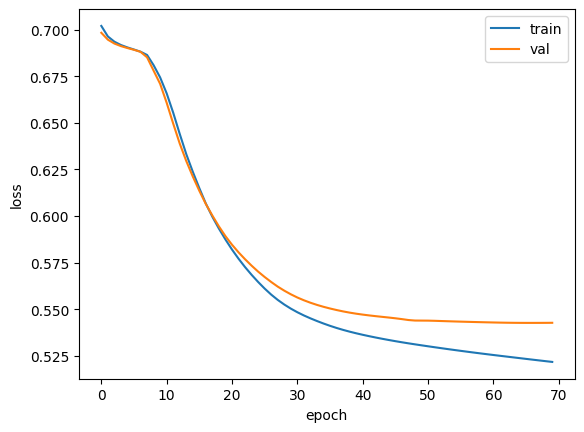

In [36]:
# 70회 에포크에서 조기 종료됨 정확도는 74% 정도 나옴
# 매우 뛰어나진 않지만 감상평을 분류 하기에는 적당할 듯

# 훈련손실과 검증손실 그래프로 나타내 보자
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()


In [37]:
# keypoint : 이 작업을 위해서 입력 데이터를 원-핫 인코딩을 사용하였음
# 원-핫 인코딩을 단점은 입력 데이터가 엄청 커짐
print(train_seq.nbytes, train_oh.nbytes)
# 토큰 1개를 300차원으로 늘렸기 때문에 썩 좋은 방법은 아님

8000000 3200000000


In [ ]:
# 단어 표현 방법 -> 원-핫인코딩 단점 해결
# 순환 신경망에서 텍스트를 처리 할 때 즐겨 사용하는 방법은 단어 임베딩(word embedding)이다.
# 단어 임베딩은 각 단어를 고정된 크기의 실수 백터로 바꾸어 줌

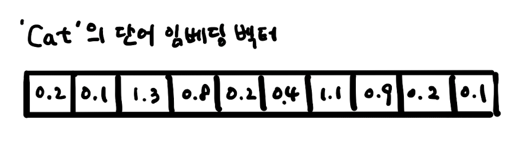

In [39]:
# 이런 단어 임베딩으로 만들어진 벡터는 원-핫인코딩보다 훨씬 의미있는 값으로 채워져 있기 때문에 자연어 처리에서 도 좋은 성능을 냄
# 물론 이런 단어 임베딩 벡터를 만드는 층은 이미 준비되어 있다. keras.layers.Embedding 클래스가 임베딩 기능을 제공
# 이 클래스를 다른 층처럼 모델에 추가하면 처음에는 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 데이터에서 좋은단어 임베딩 학습을 함
# https://casa-de-feel.tistory.com/28

# 단어 임베딩의 장점은 입력으로 정수 데이터를 받는 다는 것
# 즉 원-핫인코딩으로 변경된 train_oh 배열이 아니라 train_seq를 사용할 수 있음 (메모리 관리 유용)

# 전에 샘플 하나를 200 차원으로 늘렸기 때문에 (100,) 크기의 샘플(100,200)으로 커졌음
# 이와 비슷하게 임베딩도 (100,) 크기의 샘플(100,20)과 같이 2차원 배열로 늘림
# 하지만 원-핫 인코딩과 달리 횔씩 작은 크기로도 단어를 잘 표현할 수 있음

model2 = keras.Sequential()

model2.add(keras.layers.Embedding(200, 16, input_shape=(100,)))
# Embedding(어휘사전크기 imdb.load_data(num_words=200) , 임베딩 벡터 크기 16, 입력 시퀀스의 길이 100 )
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 16)             │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,409 (13.32 KB)

 Trainable params: 3,409 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# 임베딩 층은 (100,)을 받아 (100,16) 크기의 출력을 만듬
# 파라미터 개수 : 200개의 토큰을 받아 각 토큰크기를 16인 벡터로 변경함 200 * 16 = 3200의 모델 파라미터를 가짐
# SimpleRNN 층은 임베딩 백터의 크기가 16임으로 8개위 뉴럽과 곱하기 위해 16 * 8 = 128개를 가짐
# 은닉상태에서 곱해지는 가중지 8 * 8 = 64 가 있고 절편이 8개 있음  128 + 64 + 8 = 200
# 마지막 층은 가중치 개수는 이전과 동일하게 9 임

# 훈련시작
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5190 - loss: 0.6928 - val_accuracy: 0.6320 - val_loss: 0.6612
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6351 - loss: 0.6588 - val_accuracy: 0.6688 - val_loss: 0.6428
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6667 - loss: 0.6415 - val_accuracy: 0.6804 - val_loss: 0.6305
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6847 - loss: 0.6283 - val_accuracy: 0.6548 - val_loss: 0.6335
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6922 - loss: 0.6159 - val_accuracy: 0.6984 - val_loss: 0.6093
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7024 - loss: 0.6052 - val_accuracy: 0.6948 - val_loss: 0.6045
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7068 - loss: 0.5955 - val_accuracy: 0.6726 - val_loss: 0.6094
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7119 - loss: 0.588

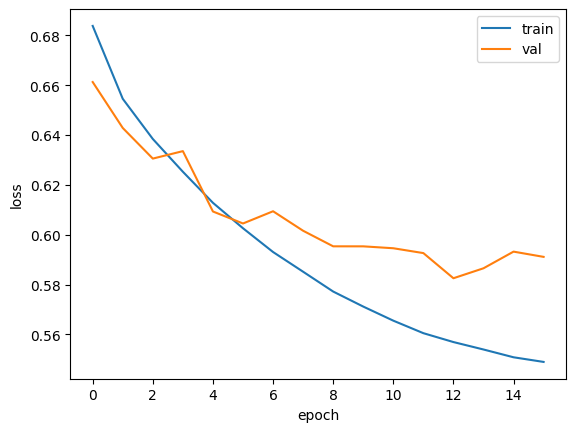

In [41]:
# 16번에 에포크로 조기 종료

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# 검증 손실이 더 감소되지 않아 적절히 조기 종료 됨